# Learned Trading Strategy

In [1]:
import numpy as np
from datetime import datetime
import pywt
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from keras import Input
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from attention import Attention
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
plt.style.use('seaborn')

In [2]:
ticker = '^GSPC'
exposureSize = 128
lookAhead = 1
numEpochs = 12
batchSize = 32
actionThreshold = 0.005

[{'uuid': 'c51ccf6e-6108-3b72-a81f-b1e3bf2e4e38', 'title': '2 No-Brainer Bio-Tech Stocks to Buy Right Now', 'publisher': 'Motley Fool', 'link': 'https://finance.yahoo.com/m/c51ccf6e-6108-3b72-a81f-b1e3bf2e4e38/2-no-brainer-bio-tech-stocks.html', 'providerPublishTime': 1660400580, 'type': 'STORY', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/s.0Sw17U6pO0UXdAB7nzJQ--~B/aD0wO3c9MDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/uu/api/res/1.2/gN8cdD.Lv2iGFMhRMVtV9Q--~B/aD0wO3c9MDthcHBpZD15dGFjaHlvbg--/https://media.zenfs.com/en/motleyfool.com/4b741f19fc3aebbc403c55bf9cfa16b7', 'width': 0, 'height': 0, 'tag': 'original'}]}, 'relatedTickers': ['EXEL', 'BMY', '^GSPC']}, {'uuid': 'bf8d1638-4c1c-3db3-8bf3-33e03031d4b0', 'title': 'New S&P 500 Member Breaks Out, Leading 5 Stocks Near Buy Points', 'publisher': "Investor's Business Daily", 'link': 'https://finance.yahoo.com/m/bf8d1638-4c1c-3db3-8bf3-33e03031d4b0/new-s%26p-500-member-breaks.html', 'providerPublishTime': 1660396

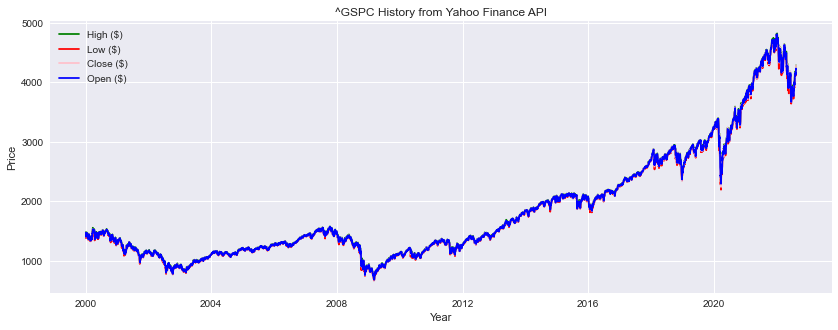

In [3]:
target = yf.Ticker(ticker)
today = datetime.now().date().strftime("%Y-%m-%d")
history = target.history(start="2000-01-01", end=today)
opens = history.Open
highs = history.High
lows = history.Low
closes = history.Close
volume = history.Volume
data = pd.concat([opens, highs, lows, closes, volume], axis=1)
copyData = data.copy()
data.dropna(inplace=True, axis=0)

print(opens.shape)
print(highs.shape)
print(lows.shape)
print(closes.shape)
print(volume.shape)
print(data.shape)

# print(target.get_news())

plt.figure(figsize=(14, 5))
plt.plot(highs, color='green', label='High ($)')
plt.plot(lows, color='red', label='Low ($)')
plt.plot(closes, color='pink', label='Close ($)')
plt.plot(opens, color='blue', label='Open ($)')
historyPlotTitle = ticker + ' History from Yahoo Finance API'
plt.title(historyPlotTitle)
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [31]:
nulls = data.isnull().sum().sum() + data.isna().sum().sum()
if (nulls == 0):
    print('Dataset is clean!')
else:
    print('Dataset is unclean!')

Dataset is clean!


In [32]:
trainingDataUnscaled, testingDataUnscaled = train_test_split(data, test_size=0.05, random_state=42, shuffle=False)
splitDate = testingDataUnscaled.index[0].date()
previousDays = trainingDataUnscaled.tail(exposureSize)
testingDataUnscaled = pd.concat([previousDays, testingDataUnscaled])

print(splitDate)
print(trainingDataUnscaled.shape)
print(testingDataUnscaled.shape)

2021-06-24
(5403, 5)
(413, 5)


In [33]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()

trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingDataNormalised = anotherScaler.fit_transform(trainingDataStandardised)

testingDataStandardised = scaler.transform(testingDataUnscaled)
testingData = anotherScaler.transform(testingDataStandardised)

In [34]:
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return reconstructedData

trainingDataUncut = np.array(WaveletTransform(trainingDataNormalised, 3))
trainingData = trainingDataUncut[7:-7,:]

In [35]:
def GetLabel(current, future):
    futureMean = future.mean()
    difference = futureMean - current
    percentageChange = difference / current
    if (abs(percentageChange) < actionThreshold): # ! Hold
        return([0, 1, 0])
    elif (difference > 0): # ! Buy
        return([1, 0, 0])
    elif (difference < 0): # ! Sell
        return([0, 0, 1])
    else:
        return(0)
    
offset = lookAhead - 1

X_train = []
y_train = []

for i in range(exposureSize, trainingData.shape[0]-offset):
    X_train.append(trainingData[i-exposureSize:i])
    y_train.append(GetLabel(trainingData[i, 0], trainingData[i:i+offset, 0]))

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(5233, 128, 5)
(5233, 3)


In [36]:
X_test = []
y_test = []

for i in range(exposureSize, testingData.shape[0]-offset):
    X_test.append(testingData[i-exposureSize:i])
    y_test.append(GetLabel(testingData[i, 0], testingData[i:i+offset, 0]))

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(256, 128, 5)
(256, 3)


### Custom Loss Function

In [ ]:
# def CalculateProfit():

2022-08-11 15:04:49.718737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 50)           11200     
                                                                 
 lstm_1 (LSTM)               (None, 128, 50)           20200     
                                                                 
 attention (Attention)       (None, 16)                4100      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 35,551
Trainable params: 35,551
Non-trainable params: 0
_________________________________________________________________
None


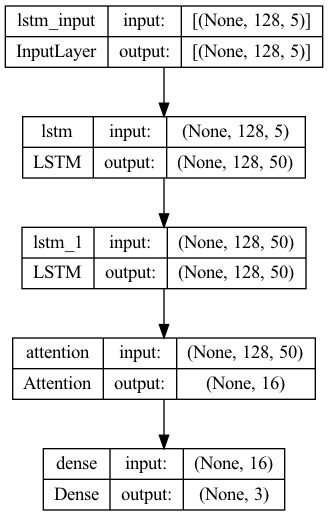

In [37]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(Attention(units=16))
model.add(Dense(3, activation='softmax'))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['acc'])
print(model.summary())
plot_model(model, to_file='./LearnedTradingStrategy.png', show_shapes=True)

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16, batch_size=32, verbose=1)

Epoch 1/16


2022-08-11 15:04:52.943898: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


164/164 [==============================] - ETA: 0s - loss: 0.8706 - acc: 0.5962

2022-08-11 15:05:04.319829: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


164/164 [==============================] - 14s 67ms/step - loss: 0.8706 - acc: 0.5962 - val_loss: 1.0548 - val_acc: 0.4492
Epoch 2/16
164/164 [==============================] - 10s 63ms/step - loss: 0.8559 - acc: 0.5993 - val_loss: 1.0837 - val_acc: 0.4492
Epoch 3/16
164/164 [==============================] - 11s 64ms/step - loss: 0.8582 - acc: 0.5993 - val_loss: 1.0269 - val_acc: 0.4492
Epoch 4/16
164/164 [==============================] - 10s 64ms/step - loss: 0.8564 - acc: 0.5991 - val_loss: 1.0947 - val_acc: 0.4492
Epoch 5/16
164/164 [==============================] - 11s 66ms/step - loss: 0.8510 - acc: 0.5995 - val_loss: 1.0602 - val_acc: 0.4492
Epoch 6/16
164/164 [==============================] - 11s 68ms/step - loss: 0.8479 - acc: 0.6016 - val_loss: 1.0651 - val_acc: 0.4492
Epoch 7/16
164/164 [==============================] - 11s 67ms/step - loss: 0.8441 - acc: 0.6002 - val_loss: 1.2007 - val_acc: 0.4492
Epoch 8/16
164/164 [==============================] - 11s 67ms/step - los

In [39]:
y_hat = model.predict(X_test)

2022-08-11 15:08:03.024255: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


8/8 [==============================] - 1s 24ms/step


In [40]:
yHatAbsolute = y_hat.copy()
yHatText = []
for i in range(len(y_hat)):
    for j in range(len(y_hat[i])):
        yHatAbsolute[i, j] = round(y_hat[i, j])
    if (yHatAbsolute[i, 0] == 1):
        yHatText.append("BUY")
    elif (yHatAbsolute[i, 1] == 1):
        yHatText.append("HOLD")
    elif (yHatAbsolute[i, 2] == 1):
        yHatText.append("SELL")

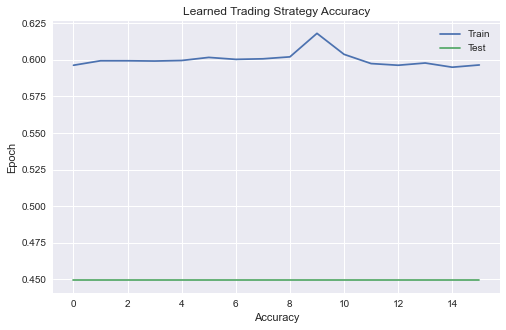

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Learned Trading Strategy Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend(['Train', 'Test'])
plt.show()

In [42]:
trainingAccuracy = history.history['acc']
validationAccuracy = history.history['val_acc']

print("Training Accuracy: " + str(trainingAccuracy[-1]))
print("Validation Accuracy: " + str(validationAccuracy[-1]))

Training Accuracy: 0.596407413482666
Validation Accuracy: 0.44921875


In [51]:
initialBalance = 1000
balance = initialBalance
actionThreshold = 0.01
betProportion = 100
bet = balance / betProportion
ownedShares = 0

buyOrders = 0
sellOrders = 0

def Buy(price):
    global balance, ownedShares, buyOrders
    if (balance > 0):
        numShares = 0
        if (balance >= bet):
            numShares = bet / price
            balance -= bet
            ownedShares += numShares
        else:
            numShares = balance / price
            balance = 0
            ownedShares += numShares
        # print("BUY - " + str(numShares) + " shares at $" + str(price))
        buyOrders += 1
        

def Sell(price):
    global balance, ownedShares, sellOrders
    if (ownedShares > 0):
        numShares = bet / price
        if (ownedShares >= numShares):
            balance += bet
            ownedShares -= numShares
            # print("SELL - " + str(numShares) + " shares at $" + str(price))
        else:
            value = ownedShares * price
            balance += value
            ownedShares = 0
            # print("SELL - " + str(ownedShares) + " shares at $" + str(price))
        sellOrders += 1

for i in range(len(yHatText)):
    if (yHatText[i] == "BUY"):
        Buy(X_test[i, -1, 0])
    elif (yHatText[i] == "SELL"):
        Sell(X_test[i, -1, 0])

totalShareValue = ownedShares * X_test[-1, -1, 0]
finalBalance = balance + totalShareValue
profit = finalBalance-initialBalance
balancePercentageChange = ((finalBalance-initialBalance)/initialBalance) * 100
pricePercentageChange = ((X_test[-1, -1, 0]-X_test[0, -1, 0])/X_test[0, -1, 0]) * 100

print("Initial Balance: $" + str(initialBalance))
print("Final Balance: $" + str(finalBalance))
print("Profit: $" + str(profit))
print("Balance Percentage Change: " + str(balancePercentageChange) + "%")
print(ticker + " Price Percentage Change: " + str(pricePercentageChange) + "%")

Initial Balance: $1000
Final Balance: $878.4735739117708
Profit: $-121.52642608822919
Balance Percentage Change: -12.152642608822918%
SPY Price Percentage Change: -7.405376541084681%
